# BLUE SQUARES

In [2]:
# imports
import cv2
import numpy as np
import os
import math
import matplotlib.pyplot as plt

## Download

In [3]:
image_path = "./archive/images"

## Pre-Process


In [4]:
def smooth(img): 

    # remove noise
    # Using a Median Filter
    img_smoothed = cv2.medianBlur(img, 5)

    return img_smoothed
    # return img

def contrastAdjust(img):

    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    h, s, v = img[:, :, 0], img[:, :, 1], img[:, :, 2]

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    v = clahe.apply(v)

    img = np.dstack((h, s, v))

    img_clean = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    
    return img_clean

def removeShadows(img):
    rgb_planes = cv2.split(img)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7, 7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 41)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(
            diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)

    img_clean = cv2.merge(result_norm_planes)

    return img_clean


In [5]:
# TODO: CHANGE THIS

def calcAngles(cnt_img, corners):
    angles = []
    
    # Calculate euclidean distance between each corner
    dist1 = int(math.sqrt(math.pow(corners[0] - corners[2], 2) +
                       math.pow(corners[1] - corners[3], 2)))
    dist2 = int(math.sqrt(math.pow(corners[2] - corners[4], 2) +
                       math.pow(corners[3] - corners[5], 2)))
    dist3 = int(math.sqrt(math.pow(corners[4] - corners[6], 2) +
                   math.pow(corners[5] - corners[7], 2)))
    dist4 = int(math.sqrt(math.pow(corners[6] - corners[0], 2) +
                   math.pow(corners[7] - corners[1], 2)))

    
    max_radius = min([dist1, dist2, dist3, dist4])

    for i in range(len(corners[:-1]), 2):
        blank_img = np.zeros((len(cnt_img), len(cnt_img[0])), np.uint8)
        cv2.circle(blank_img, (corners[i], corners[i + 1]),
                  max_radius // 2, (255, 255, 255))
        intersect_img = cv2.bitwise_and(cnt_img, blank_img)

        intersect_pts = np.where(intersect_img > 1)

        if(len(intersect_pts[0]) < 2 or len(intersect_pts[1]) < 2):
            angles.append(0)
            continue

        vector1 = (intersect_pts[1][0] - corners[i],
                   intersect_pts[0][0] - corners[i + 1])
        vector2 = (intersect_pts[1][1] - corners[i],
                   intersect_pts[0][1] - corners[i + 1])

        scalar_p = vector1[0] * vector2[0] + vector1[1] * vector2[1]
        norm1 = math.sqrt(math.pow(vector1[0], 2) + math.pow(vector1[1], 2))
        norm2 = math.sqrt(math.pow(vector2[0], 2) + math.pow(vector2[1], 2))

        angle = math.acos(scalar_p / (norm1 * norm2)) * 180 / math.pi
        angles.append(angle)

    return angles


## Feature Recognition 

In [6]:
def featureRecognition(img): 

    # Segmentation to recognize colour blue
    # Converts images from BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Bounds adjusted to identify shades of blue correspondent to traffic signs
    lower_blue = np.array([100, 100, 80])
    upper_blue = np.array([150, 255, 255])

    # Here we are defining range of bluecolor in HSV
    # This creates a mask of blue coloured
    # objects found in the frame.
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # The bitwise and of the frame and mask is done so
    # that only the blue coloured objects are highlighted
    # and stored in res
    res = cv2.bitwise_and(img, img, mask=mask)
    cv2.imshow('original', img)
    cv2.imshow('mask', mask)
    cv2.imshow('res', res)



    # TEST SEGMENTATION
    cv2.waitKey()

    # Destroys all of the HighGUI windows.
    cv2.destroyAllWindows()


    # Post-Segmentation smoothing 
    # res = smooth(res)  


    # Contours on Resulting Image
    gray_img = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
    # Apply Canny
    canny = cv2.Canny(gray_img, 130, 255)

    # Find Contours
    # RETR_CCOMP: retrieves all of the contours and organizes them into a two-level hierarchy. At the top level, there are external boundaries of the components. 
    # At the second level, there are boundaries of the holes. If there is another contour inside a hole of a connected component, it is still put at the top level.
    cnts = cv2.findContours(
        canny, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]


    for c in range(len(cnts)):
        cnt_len = cv2.arcLength(cnts[c], True)

        # Small contours will appear in green; can be commented and code will still work
        if(cnt_len <= 70):
            cv2.drawContours(img, [cnts[c]], 0, (0, 255, 0), 3)
            continue 

        # Recognize most approximate CLOSED Poly-shape to contour to draw
        approx_poly = cv2.approxPolyDP(
            cnts[c], 0.03 * cv2.arcLength(cnts[c], True), True)

        # Rectangle Recognition through Distance and Angle Analysis
        ravel = approx_poly.ravel()
        n_sides = len(approx_poly)
        angle_cdt = False 

        # Nº of Sides is 4 = Square/Rectangle
        if(n_sides == 4): 
            angle_cdt = True 

            cnt_img = np.zeros((len(img), len(img[0])), np.uint8)
            angles = calcAngles(cv2.drawContours(cnt_img, [approx_poly], -1, (255), 1), ravel)

            for a in angles:
                if(abs(a - 90) > 10):
                    angle_cdt=False
                    break
            
        if(angle_cdt):
            img = cv2.drawContours(img, [approx_poly], -1, (0, 230, 255), 3)

    
    cv2.imshow("result", img)



    # TEST contours
    cv2.waitKey()

    # Destroys all of the HighGUI windows.
    cv2.destroyAllWindows()


In [78]:
#SIFT & FLANN & RANSAC
def featureDetectionAndMatching(img, img_train):

    MIN_MATCH_COUNT = 5

    # Initiate SIFT detector
    sift = cv2.SIFT_create()

    
    # find the keypoints & compute descriptors
    kp, des = sift.detectAndCompute(img_train, None)
    kp2, des2 = sift.detectAndCompute(img, None)


    # create FLANN feature matcher
    FLANN_INDEX_KDTREE = 1

    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des, des2, k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m, n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    if len(good) >= MIN_MATCH_COUNT:
        src_pts = np.float32([kp[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()
        h, w = img_train.shape[:2]
        pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]
                        ).reshape(-1, 1, 2)
        if not M is None:
            dst = cv2.perspectiveTransform(pts, M)
            img = cv2.polylines(img, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
        else: 
            print("No homography found...")
            return -1
    else:
        print("Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT))
        matchesMask = None
        return -1


    # draw match if matched, keypoints if not
    draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                       singlePointColor=None,
                       matchesMask=matchesMask,  # draw only inliers
                       flags=2)


    img_result = cv2.drawMatches(img_train, kp, img, kp2, good, None, **draw_params)

    img_result = cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(img_result, 'gray'), plt.show()

    return 1


## Main Loop

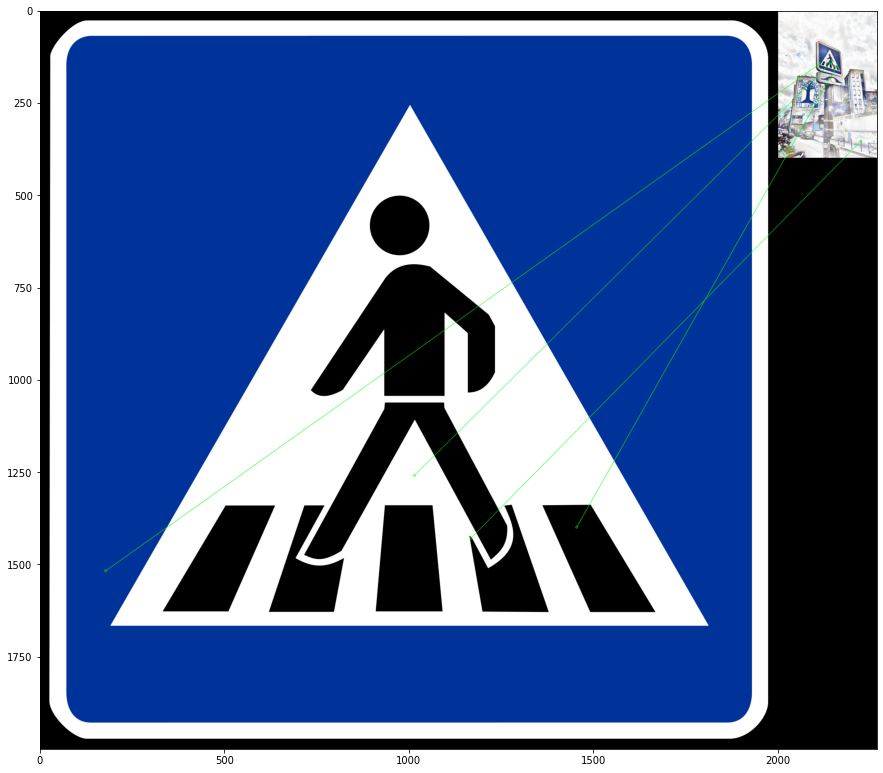

1

In [79]:
img = cv2.imread(os.path.join(image_path, 'road126.png'))


img_train = cv2.imread('./train-img/crossing.png')

img_clean = removeShadows(contrastAdjust(img))
# featureRecognition(img_clean)

# TODO: passar enum de paths com imagens de treino, correr enum dentro da função, retornar quando encontrar melhor match
featureDetectionAndMatching(img_clean, img_train)


## Results

## Images to check with blue squares

- 122 
- 123 - needs adjustments
- 124
- 125 - not working
- 126 - not working 
- 127 - not working
- 128 - not working
- 129 - not working 
- 130 - not working 
- 131 - not working
- 132
- 133??? (cleaning + sementation)
- 134 - needs adjustments (segmentation)
- 135 - needs adjustments (segmentation)
- 136 - not working
- 137 
- 138 - not working
- 139 - not working (segmentation)
- 140 - not working (angles)
- 141 - not working (segmentation)
- 142 - not working (segmentation)
- 143??? 
- 144 
- 145??? angles?
- 146 
- 147 - same as 145
- 148 - needs adjustments (segmentation + contours)
- 149 - segmentation
- 150 - not working
- 151?
- 152
- 153 - needs adjustments (contours)
- 154 - too far
- 155 
- 156 - contours
- 157 - contours
- 158 - segmentation
- 159 - surprisingly works
- 160 - segmentation
- 161 - segmentation
- 163
- 164 - cut in the middle (extra)
- 165 - segmentation
- 166
- 167 - segmentation - dark
- 168??
- 170 - segmentation + contours
- 171 - awful image
- 172 - awful image
- 174 - segmentation
- 175 - segmentation + contours
- 176 - segmentation
- 178
- 180 - segmentation
- 183 - segmentation
- 184 - recognizes shape when it shouldn't
- 186 - segmentation
- 187 - segmentation
- 188 - contouring
- 189 - segmentation 
- 190 - segmentation
- 191 - cut sign (extra)
- 193 - contouring
- 194 - segmentation
- 200 - segmentation + contouring
- 204 - segmentation
- 205 - segmentation
- 206 - contouring
- 207 - awful image
- 224 - awful image
- 226 - contouring
- 237 - awful image
- 238 - awful image
- 239 - awful image
- 253 - segmentation
- 254 - segmentation
- 255 - segmentation
- 256 - segmentation
- 257 - awful image
- 258 - awful image
- 259 - segmentation
- 260 - segmentation


- 294 - not working
- 299 - not working
- 309
- 311
- 318

TODO: Consider **checking binarization**, image segmentation with threshholding and feature recognition classic techniques using query images to compare features